In [1]:
import sys

sys.path.append("..")
import numpy as np
from LSBSteg import decode
from helpers import *
import requests
from keras.models import load_model
import time


In [9]:
print("Loading model...")
model = load_model("spectro.keras")
model.predict(np.zeros((1, 1998, 101, 1)))
print("Model loaded")

Loading model...
1/1 [==============================] - 8s 8s/step
Model loaded


In [31]:
def remaining_attempts(team_id):
    """
    In this fucntion you need to hit to the endpoint to start the game as an eagle with your team id.
    If a sucessful response is returned, you will recive back the first footprints.
    """
    endpoint = "http://13.53.169.72:5000/attempts/student"
    request_data = {"teamId": team_id}
    response = requests.post(
        endpoint,
        json=request_data,
    )
    dump_response("remaining attempts", request_data, response)
    response_data = response.json()
    print(response_data, response.status_code)


def init_eagle(team_id):
    """
    In this fucntion you need to hit to the endpoint to start the game as an eagle with your team id.
    If a sucessful response is returned, you will recive back the first footprints.
    """
    endpoint = "/eagle/start"
    request_data = {"teamId": team_id}
    start = time.time()
    response = requests.post(
        api_base_url + endpoint,
        json=request_data,
    )
    print("INIT REQUEST REAL TIME... ", time.time() - start)
    dump_response("eagle_start", request_data, response)
    try:
        response_data = response.json()
    except:
        response_data = response.text
    return response_data


def skip_msg(team_id):
    """
    If you decide to NOT listen to ANY of the 3 channels then you need to hit the end point skipping the message.
    If sucessful request to the end point , you will expect to have back new footprints IF ANY.
    """
    endpoint = "/eagle/skip-message"
    request_data = {"teamId": team_id}
    response = requests.post(
        api_base_url + endpoint,
        json=request_data,
    )
    try:
        response_data = response.json()
    except:
        response_data = response.text
    dump_response("eagle_skip_msg", request_data, response)
    return response_data


def request_msg(team_id, channel_id):
    """
    If you decide to listen to any of the 3 channels then you need to hit the end point of selecting a channel to hear on (1,2 or 3)
    """
    endpoint = "/eagle/request-message"
    request_data = {"teamId": team_id, "channelId": int(channel_id)}
    response = requests.post(
        api_base_url + endpoint,
        json=request_data,
    )
    try:
        response_data = response.json()
    except:
        response_data = response.text
    dump_response("eagle_request_msg", request_data, response)
    return response_data


def submit_msg(team_id, decoded_msg):
    """
    In this function you are expected to:
        1. Decode the message you requested previously
        2. call the api end point to send your decoded message
    If sucessful request to the end point , you will expect to have back new footprints IF ANY.
    """
    endpoint = "/eagle/submit-message"
    request_data = {"teamId": team_id, "decodedMsg": decoded_msg}
    response = requests.post(
        api_base_url + endpoint,
        json=request_data,
    )
    try:
        response_data = response.json()
    except:
        response_data = response.text
    dump_response("eagle_submit_msg", request_data, response)

    return response_data


def end_eagle(team_id):
    """
    Use this function to call the api end point of ending the eagle  game.
    Note that:
    1. Not calling this fucntion will cost you in the scoring function
    """
    endpoint = "/eagle/end-game"
    request_data = {"teamId": team_id}
    response = requests.post(
        api_base_url + endpoint,
        json=request_data,
    )
    try:
        response_data = response.json()
    except:
        response_data = response.text
    dump_response("eagle_end", request_data, response)
    print(response_data, response.status_code)


def submit_eagle_attempt(team_id):
    """
    Call this function to start playing as an eagle.
    You should submit with your own team id that was sent to you in the email.
    Remeber you have up to 15 Submissions as an Eagle In phase1.
    In this function you should:
       1. Initialize the game as fox
       2. Solve the footprints to know which channel to listen on if any.
       3. Select a channel to hear on OR send skip request.
       4. Submit your answer in case you listened on any channel
       5. End the Game
    """
    # first = True
    start = time.time()
    response_data = init_eagle(team_id)
    print("init time: ", time.time() - start)
    while response_data != "End of message reached":
        try:
            footprints = response_data["footprint"]
        except:
            footprints = response_data["nextFootprint"]
        
        start = time.time()
        channel_id = evaluate_footprints(footprints, model)
        print("evaluation time: ", time.time() - start)
        if channel_id == 0:
            start = time.time()
            response_data = skip_msg(team_id)
            print("skipping time: ", time.time() - start)
        else:
            start = time.time()
            response_data = request_msg(team_id, channel_id)
            print("requesting time: ", time.time() - start)
            encoded_msg = response_data["encodedMsg"]
            start = time.time()
            decoded_msg = decode(np.array(encoded_msg))
            print("decoding time: ", time.time() - start)
            start = time.time()
            response_data = submit_msg(team_id, decoded_msg)
            print("submitting time: ", time.time() - start)

    end_eagle(team_id)


In [32]:
team_id = "TPRTO2z"

In [33]:
remaining_attempts(team_id)

{'remaining_eagle_attempts': 12, 'remaining_fox_attempts': 13} 200


In [38]:
api_base_url = "http://3.70.97.142:5000"

In [39]:
submit_eagle_attempt(team_id)

INIT REQUEST REAL TIME...  3.430800199508667
init time:  4.00291109085083
evaluation time:  0.29632997512817383
skipping time:  0.18805384635925293
Game ended successfully with a score of 17.635924732394365. Which is not higher than your highest score. 200


In [40]:
save_logs("eagle_logs4.txt")

In [120]:
def plot_spectrogram(spectrogram, ax=None):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(np.float32).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, width, num=width, dtype=int)
    Y = range(height)
    if ax is None:
        plt.pcolormesh(X, Y, log_spec)
        plt.colorbar(label="Intensity")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Spectrogram")
    else:
        ax.pcolormesh(X, Y, log_spec)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title("Spectrogram")

In [114]:
from helpers import *

In [74]:
with open("eagle_imgs2.txt", "r") as f:
    img = f.read().replace("'", '"').replace("inf", "-111111111111111")
js = json.loads(img)

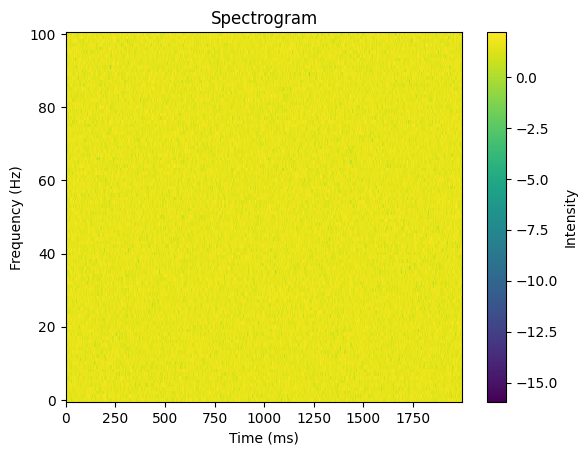

In [121]:
spectro = np.array(js['footprint']['3'])
spectro[spectro == -111111111111111] = np.inf
plot_spectrogram(spectro + spectro.min()*-1)

In [127]:
np.log(spectro + spectro.min()*-1+ np.finfo(np.float32).eps).max()

2.1989591963709483

In [111]:
spectro.T[2][-1] + np.finfo(np.float32).eps*100000

-0.3550224304199219

In [60]:
def _process_footprint(footprint: dict):
    spectro = np.array(footprint)
    spectro[spectro == np.inf] = np.float16(65500.0)
    spectro = spectro.reshape(1, *spectro.shape, 1)

    return spectro

In [79]:
spectro = _process_footprint(spectro)

In [80]:
model.predict(spectro)

1/1 [==============================] - 0s 47ms/step


array([[-0.16210322]], dtype=float32)